In [44]:
import os
import gc
import json
import math
import pickle
import subprocess
import collections
import unicodedata

import torch.nn as nn
import torch.optim as optim

# 3rd-party package imports, may require installation if not on a platform such as Colab.

import numpy
import torch
import pandas as pd
import tqdm.auto as tqdm

import matplotlib
from matplotlib import pyplot
from nltk.translate import bleu_score
from torch.utils.data import TensorDataset, DataLoader

# Please do not change anything in the following cell

# Find and load fonts that can display Hindi characters, for Matplotlib
result = subprocess.run([ 'fc-list', ':lang=hi', 'family' ], capture_output=True)
found_hindi_fonts = result.stdout.decode('utf-8').strip().split('\n')

matplotlib.rcParams['font.sans-serif'] = [
    'Source Han Sans TW', 'sans-serif', 'Arial Unicode MS',
    *found_hindi_fonts
]

# Please do not change anything in the following cell
STUDENT_SAP_NAME = 'Dhanesh'
STUDENT_SR_NUMBER = 22476

DIRECTORY_NAME = f"{STUDENT_SAP_NAME.replace(' ', '_')}_{STUDENT_SR_NUMBER}"

# os.makedirs(DIRECTORY_NAME, exist_ok=True)

def sync_vram():
    """ Synchronizes the VRAM across the GPUs, reclaiming unused memory. """
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

"""## Data Preparation

We'll load the data for the task, which comprises of a parallel corpus of Indian Names and their Hindi equivalents.
"""

# Make sure your code is not dependent on any of the file names as below.

# Download the training and validation datasets
!wget -O data.train.csv "https://docs.google.com/spreadsheets/d/1JpK9nOuZ2ctMrjNL-C0ghUQ4TesTrMER1-dTD_torAA/gviz/tq?tqx=out:csv&sheet=data.train.csv"
!wget -O data.valid.csv "https://docs.google.com/spreadsheets/d/1cKC0WpWpIQJkaqnFb7Ou7d0syFDsj6eEW7bM7GH3u2k/gviz/tq?tqx=out:csv&sheet=data.valid.csv"


--2024-09-24 00:22:23--  https://docs.google.com/spreadsheets/d/1JpK9nOuZ2ctMrjNL-C0ghUQ4TesTrMER1-dTD_torAA/gviz/tq?tqx=out:csv&sheet=data.train.csv
Resolving docs.google.com (docs.google.com)... 142.250.192.14, 2404:6800:4009:832::200e
Connecting to docs.google.com (docs.google.com)|142.250.192.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data.train.csv’

data.train.csv          [ <=>                ] 126.35K  --.-KB/s    in 0.09s   

2024-09-24 00:22:24 (1.42 MB/s) - ‘data.train.csv’ saved [129381]

--2024-09-24 00:22:26--  https://docs.google.com/spreadsheets/d/1cKC0WpWpIQJkaqnFb7Ou7d0syFDsj6eEW7bM7GH3u2k/gviz/tq?tqx=out:csv&sheet=data.valid.csv
Resolving docs.google.com (docs.google.com)... 142.250.192.14, 2404:6800:4009:832::200e
Connecting to docs.google.com (docs.google.com)|142.250.192.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data.valid.csv’

In [45]:
# Please do not change anything in the following cell

def read_dataframe(ds_type):
    """ Loads a dataframe based on the given partition type.

    Args:
        ds_type (str): Dataset type: train (train) or validation (valid)

    Returns:
        pd.DataFrame: Pandas Dataframe for the specified partition.
    """

    df = pd.read_csv(f"data.{ds_type}.csv", header=0)
    df = df[~df.isna()]
    df['Name'] = df['Name'].astype(str)
    df['Translation'] = df['Translation'].astype(str)
    return df

# Load the training and validation datasets
train_data      = read_dataframe("train")
validation_data = read_dataframe("valid")

print(f"Length of training data: {len(train_data)}\nLength of validation data: {len(validation_data)}")

Length of training data: 4484
Length of validation data: 400


In [46]:
"""Here are some examples from the training dataset. Note that the dataset may be noisy so some examples may not be perfect:"""

train_data.sample(n=5)

"""## Tokenization

Now with the data, you must first prepare a tokenization strategy for feeding name pairs as a sequence to different models. For English this could be as simple as using individual characters as tokens, but Hindi has accents (मात्राएँ), a larger set of vowels (स्वर), consonants (व्यंजन), and additional composition rules (half-letters, etc.), so such a simple strategy may not be effective.

In NLP literature, multiple strategies exist for automatically learning a suitable sub-word tokenization strategy from the given data. Such tokenizers exist in two types:
- Given a set of initial tokens, learn suitable combinations which are added as new tokens until a certain vocabulary size is reached. Examples of these include [BPE Tokenization](https://arxiv.org/abs/1508.07909) and [WordPiece Tokenization, introduced by the BERT paper](https://arxiv.org/abs/1810.04805).
- Given a large set of initial tokens, learn suitable rules to reduce the size of the vocabulary to a desired size. An example of this includes [SentencePiece Tokenization](https://arxiv.org/abs/1808.06226).

Given empirical results, these are popular strategies to learn tokenization automatically from given data.

In this section, you will implement a tokenizer for the given data. There could be multiple strategies to implement tokenizers:
- You can have a tokenizer that operates jointly over both languages or have separate tokenizers for English and Hindi.
- Your tokenizer can learn the tokenization from data (using any one of the techniques mentioned above) or can use a fixed set of rules for decomposition.

Implement the logic for any tokenizer of your choice in the class `Tokenizer` below. Make sure to adhere to the rules and constraints in the docstrings.

The tokenizer will learn a mapping of tokens to ids and vice versa and use these to map strings. This mapping can be built based on merge rules (BPE, WordPiece, etc.) or hand-crafted rules, in the `Tokenizer.train()` function. Additionally the tokenizer will also handle preprocessing and postprocessing of strings during the encoding phase (string to tokens).
"""

import re

## ==== BEGIN EVALUATION PORTION

class Tokenizer:
    """ Represents the tokenizer for text data.
        Provides methods to encode and decode strings (as instance or as a batch). """

    def __init__(self):
        """ Initializes a new tokenizer.

            Any variables required in intermediate operations are declared here.
            You will also need to define things like special tokens and other things here.

            All variables declared in this function will be serialized
                and deserialized when loading and saving the Tokenizer.
            """

        # BEGIN CODE : tokenizer.init

        # ADD YOUR CODE HERE
        self.special_tokens = {'<START>' : 0 , '[EOS]' : 1  , '<PAD>' : 2  , '<UNK>' : 3}
        self.token_to_id =  self.special_tokens
        self.id_to_token = {v:k for k,v in self.token_to_id.items()}
        self.merges = {}

        # END CODE

    @classmethod
    def load(cls, path):
        """ Loads a pre-trained tokenizer from the given directory.
           This directory will have a tokenizer.pkl file that contains all the tokenizer variables.

        Args:
            path (str): Path to load the tokenizer from.
        """
        tokenizer_file = os.path.join(path, "tokenizer.pkl")

        if not os.path.exists(path) or not os.path.exists(os.path.join(path, "tokenizer.pkl")):
            raise ValueError(cls.load.__name__ + ": No tokenizer found at the specified directory")

        with open(tokenizer_file, "rb") as ifile:
            return pickle.load(ifile)

    def save(self, path):
        """ Saves a trained tokenizer to a given directory, inside a tokenizer.pkl file.

        Args:
            path (str): Directory to save the tokenizer in.
        """

        os.makedirs(path, exist_ok=True)
        with open(os.path.join(path, "tokenizer.pkl"), 'wb') as ofile:
            pickle.dump(self, ofile)

    def split_text_with_punctuation(self,text):
        # Define common punctuation marks for both English and Hindi
        punctuation_marks = r'[.,\/#!$%\^&\*;:{}=\-_`~()\[\]\“\”\"\'\’]'

        # Split text at punctuation marks
        segments = re.split(punctuation_marks, text)

        # Initialize list for characters
        characters = []

        # Iterate over segments
        for segment in segments:
            # Split segment into characters
            chars = [char for char in segment if char != ' ']
            # Append characters to list
            characters.extend(chars)

        return characters

    def get_stats(self,ids):
        counts = {}
        for lst in ids:
            for pair in zip(lst,lst[1:]):
                counts[pair] = counts.get(pair,0)+1

        # for pair in zip(ids, ids[1:]): # Pythonic way to iterate consecutive elements
        #     counts[pair] = counts.get(pair, 0) + 1
        return counts

    def merge(self,ids, pair, idx):
        newids = []
        i = 0
        # print(pair)
        for lst in ids:
            # print(lst)
            temp = []
            i = 0
            while i < len(lst):
                if i < len(lst) - 1 and lst[i] == pair[0] and lst[i+1] == pair[1]:
                    temp.append(idx)
                    i += 2
                else:
                    temp.append(lst[i])
                    i += 1
            # print(temp)
            newids.append(temp)
        return newids

    def initialencode(self,name):
        tokens = []
        # tokens.append(self.token_to_id['<START>'])
        characters = self.split_text_with_punctuation(name)
        for char in characters:
            if char not in self.token_to_id:
                tokens.append(self.token_to_id['<UNK>'])
            else:
                tokens.append(self.token_to_id[char])
        # tokens.append(self.token_to_id['<END>'])
        return tokens

    def train(self, data, vocab_size):
        """ Trains a tokenizer to learn meaningful representations from input data.
            In the end, learns a vocabulary of a fixed size over the given data.
            Special tokens, if any, must not be counted towards this vocabulary.

        Args:
            data (list[str]): List of input strings from a text corpus.
            vocab_size (int): Final desired size of the vocab to be learnt.
        """

        # BEGIN CODE : tokenizer.train

        # ADD YOUR CODE HERE
        n = 4

        # print(data)

        for name in data:
            characters = self.split_text_with_punctuation(name)
            for char in characters:
                if char not in self.token_to_id:
                    self.token_to_id[char] = n
                    self.id_to_token[n] = char
                    n = n+1

        token_data = []

        for name in data:
            tokens = self.initialencode(name)
            token_data.append(tokens)

        ids = token_data # copy so we don't destroy the original list

        num_merges = abs(len(self.token_to_id) - vocab_size)

        for i in range(num_merges):
            stats = self.get_stats(ids)
            pair = max(stats, key=stats.get)
            idx = n + i

            ch = self.id_to_token[pair[0]] + self.id_to_token[pair[1]]

            self.token_to_id[ch] = idx
            self.id_to_token[idx] = ch

            print(f"merging {pair} into a new token {idx}")
            ids = self.merge(ids, pair, idx)

            self.merges[pair] = idx

        # END CODE


    def pad(self, tokens, length):
        """ Pads a tokenized string to a specified length, for batch processing.

        Args:
            tokens (list[int]): Encoded token string to be padded.
            length (int): Length of tokens to pad to.

        Returns:
            list[int]: Token string padded to desired length.
        """

        # BEGIN CODE : tokenizer.pad

        # ADD YOUR CODE HERE
        paded_tokens = tokens[:length] + [self.special_tokens["<PAD>"]] * max(0,length-len(tokens))
        return paded_tokens

        # END CODE

    def unpad(self, tokens):
        """ Removes padding from a token string.

        Args:
            tokens (list[int]): Encoded token string with padding.

        Returns:
            list[int]: Token string with padding removed.
        """

        # BEGIN CODE : tokenizer.unpad

        # ADD YOUR CODE HERE
        return [token for token in tokens if token != self.special_tokens["<PAD>"]]


        # END CODE

    def get_special_tokens(self):
        """ Returns the associated special tokens.

            Returns:
                dict[str, int]: Mapping describing the special tokens, if any.
                    This is a mapping between a string segment (token) and its associated id (token_id).
        """

        # BEGIN CODE : tokenizer.get_special_tokens

        # ADD YOUR CODE HERE
        return self.special_tokens

        # END CODE

    def get_vocabulary(self):
        """ Returns the learnt vocabulary post the training process.

            Returns:
                dict[str, int]: Mapping describing the vocabulary and special tokens, if any.
                    This is a mapping between a string segment (token) and its associated id (token_id).
        """

        # BEGIN CODE : tokenizer.get_vocabulary

        # ADD YOUR CODE HERE
        return self.token_to_id

        # END CODE

    def encode(self, string, add_start=True, add_end=True):
        """ Encodes a string into a list of tokens.

        Args:
            string (str): Input string to be tokenized.
            add_start (bool): If true, adds the start of sequence token.
            add_end (bool): If true, adds the end of sequence token.
        Returns:
            list[int]: List of tokens (unpadded).
        """

        # BEGIN CODE : tokenizer.encode

        # ADD YOUR CODE HERE
        tokens = []
        if(add_start):
            tokens.append(self.token_to_id['<START>'])

        string = self.split_text_with_punctuation(string)

        subword = ""

        for char in string:
            subword = subword + char
            # print(subword)
            if subword not in self.token_to_id:
                if subword[:-1] not in self.token_to_id:
                    tokens.append(self.token_to_id["<UNK>"])
                else:
                    tokens.append(self.token_to_id[subword[:-1]])
                subword = ""
                subword += char
            else:
                continue


        if(subword in self.token_to_id):
            tokens.append(self.token_to_id[subword])
        else:
            tokens.append(self.token_to_id["<UNK>"])
        # else:
        #     if subword[:-1] != "":
        #         tokens.append(self.token_to_id[subword[:-1]])
        #         if subword[-1] in self.token_to_id:
        #             tokens.append(self.token_to_id[char])
        #         else:
        #             tokens.append(self.token_to_id["<UNK>"])
        #     else:
        #         if subword[-1] in self.token_to_id:
        #             tokens.append(self.token_to_id[char])

        if(add_end):
            tokens.append(self.token_to_id['[EOS]'])

        return tokens

        # END CODE

    def decode(self, tokens, strip_special=True):
        """ Decodes a string from a list of tokens.
            Undoes the tokenization, returning back the input string.

        Args:
            tokens (list[int]): List of encoded tokens to be decoded. No padding is assumed.
            strip_special (bool): Whether to remove special tokens or not.

        Returns:
            str: Decoded string.
        """

        # BEGIN CODE : tokenizer.decode

        # ADD YOUR CODE HERE
        if(strip_special == True):
            tokens = tokens[1:-1]

        text = ""

        for idx in tokens:
            if idx in self.id_to_token and self.id_to_token[idx] != '<PAD>':
                text = text+self.id_to_token[idx]

        # text = "".join(self.id_to_token[idx] for idx in tokens)
        # text = tokens.decode("utf-8", errors="replace")
        return text

        # END CODE


    def batch_encode(self, batch, padding=None, add_start=True, add_end=True):
        """Encodes multiple strings in a batch to list of tokens padded to a given size.

        Args:
            batch (list[str]): List of strings to be tokenized.
            padding (int, optional): Optional, desired tokenized length. Outputs will be padded to fit this length.
            add_start (bool): If true, adds the start of sequence token.
            add_end (bool): If true, adds the end of sequence token.

        Returns:
            list[list[int]]: List of tokenized outputs, padded to the same length.
        """

        batch_output = [ self.encode(string, add_start, add_end) for string in batch ]
        if padding:
            for i, tokens in enumerate(batch_output):
                if len(tokens) < padding:
                    batch_output[i] = self.pad(tokens, padding)
        return batch_output

    def batch_decode(self, batch, strip_special=True):
        """ Decodes a batch of encoded tokens to normal strings.

        Args:
            batch (list[list[int]]): List of encoded token strings, optionally padded.
            strip_special (bool): Whether to remove special tokens or not.

        Returns:
            list[str]: Decoded strings after padding is removed.
        """
        return [ self.decode(self.unpad(tokens), strip_special=strip_special) for tokens in batch ]

## ==== END EVALUATION PORTION

In [47]:
"""Now with the tokenizer class, initialize and train the tokenizers for processing the parallel corpus:"""

## ==== BEGIN EVALUATION PORTION

# BEGIN CODE : tokenizer.create

# Initialize the tokenizers as per the desired strategy.
# ADD YOUR CODE HERE
src_tokenizer = Tokenizer()
tgt_tokenizer = Tokenizer()

# END CODE

## ==== END EVALUATION PORTION

## ==== BEGIN EVALUATION PORTION

# Edit the hyperparameters below as desired.
SRC_VOCAB_SIZE = 300
TGT_VOCAB_SIZE = 300

# BEGIN CODE : tokenizer.training

# Train your tokenizer(s)
# ADD YOUR CODE HERE
train_data_src = train_data['Name'].tolist()
train_data_tgt = train_data['Translation'].tolist()

# print(train_data_src)

# Train your tokenizer(s)
src_tokenizer.train(train_data_src, SRC_VOCAB_SIZE)
tgt_tokenizer.train(train_data_tgt, TGT_VOCAB_SIZE)


# END CODE

## ==== END EVALUATION PORTION

merging (4, 14) into a new token 32
merging (10, 6) into a new token 33
merging (11, 4) into a new token 34
merging (4, 11) into a new token 35
merging (4, 12) into a new token 36
merging (9, 9) into a new token 37
merging (7, 14) into a new token 38
merging (4, 21) into a new token 39
merging (14, 4) into a new token 40
merging (6, 4) into a new token 41
merging (10, 4) into a new token 42
merging (21, 4) into a new token 43
merging (7, 16) into a new token 44
merging (10, 24) into a new token 45
merging (13, 4) into a new token 46
merging (33, 4) into a new token 47
merging (8, 9) into a new token 48
merging (23, 6) into a new token 49
merging (18, 4) into a new token 50
merging (12, 4) into a new token 51
merging (34, 21) into a new token 52
merging (20, 4) into a new token 53
merging (16, 7) into a new token 54
merging (19, 7) into a new token 55
merging (9, 14) into a new token 56
merging (11, 7) into a new token 57
merging (8, 6) into a new token 58
merging (16, 4) into a new tok

In [48]:
# Please do not change anything in the following cell

# Save the trained tokenizers
src_tokenizer.save(os.path.join(DIRECTORY_NAME, "src_tokenizer"))
tgt_tokenizer.save(os.path.join(DIRECTORY_NAME, "tgt_tokenizer"))


In [49]:
# Please do not change anything in the following cell

def render_glyph(token):
    """ Renders a token, handling invalid bytes in a safe, error-proof manner. """

    token = token.decode('utf-8', errors='replace') if isinstance(token, bytes) else token
    return "".join([ c if unicodedata.category(c)[0] != "C" else f"\\u{ord(c):04x}" for c in token ])

def inverse_vocabulary(tokenizer):
    """ Generates an inverse vocabulary with rendered tokens.

    Args:
        tokenizer (Tokenizer): Tokenizer whose vocabulary must be used.
    """

    return { id: render_glyph(token) for token, id in tokenizer.get_vocabulary().items() }

def apply_inverse_vocab(tokens, inv_vocab):
    """ Decodes using the given inverse vocabulary.

    Args:
        tokens (list[int]): Tokens to process.
        inv_vocab (dict[int, str]): Inverse vocabulary for mapping ids to tokens.

    Returns:
        list[str]: Mapped token glyphs.
    """

    return [ inv_vocab[id] for id in tokens ]

In [50]:
"""We visualize a few outputs of the learnt tokenizers to assess their working:"""

# Please do not change anything in the following cell

src_id_to_token = inverse_vocabulary(src_tokenizer)

for example in train_data['Name'].sample(n=5, random_state=20240227):
    print("Name           :", example)
    tokens = src_tokenizer.encode(example)
    print("Tokens         :", tokens)
    print("Tokens (glyphs):", apply_inverse_vocab(tokens, src_id_to_token))
    print("Decoded        :", src_tokenizer.decode(tokens), end='\n\n')

Name           : prya
Tokens         : [0, 94, 46, 1]
Tokens (glyphs): ['<START>', 'pr', 'ya', '[EOS]']
Decoded        : prya

Name           : jamal
Tokens         : [0, 187, 36, 1]
Tokens (glyphs): ['<START>', 'jam', 'al', '[EOS]']
Decoded        : jamal

Name           : jag
Tokens         : [0, 207, 1]
Tokens (glyphs): ['<START>', 'jag', '[EOS]']
Decoded        : jag

Name           : sampat
Tokens         : [0, 137, 76, 16, 1]
Tokens (glyphs): ['<START>', 'sam', 'pa', 't', '[EOS]']
Decoded        : sampat

Name           : amar
Tokens         : [0, 39, 35, 1]
Tokens (glyphs): ['<START>', 'am', 'ar', '[EOS]']
Decoded        : amar



In [51]:
# Please do not change anything in the following cell

tgt_id_to_token = inverse_vocabulary(tgt_tokenizer)

for example in train_data['Translation'].sample(n=5, random_state=20240227):
    print("Name           :", example)
    tokens = tgt_tokenizer.encode(example)
    print("Tokens         :", tokens)
    print("Tokens (glyphs):", apply_inverse_vocab(tokens, tgt_id_to_token))
    print("Decoded        :", tgt_tokenizer.decode(tokens), end='\n\n')


Name           : प्र्या
Tokens         : [0, 81, 199, 1]
Tokens (glyphs): ['<START>', 'प्र', '्या', '[EOS]']
Decoded        : प्र्या

Name           : जमाल
Tokens         : [0, 24, 65, 14, 1]
Tokens (glyphs): ['<START>', 'ज', 'मा', 'ल', '[EOS]']
Decoded        : जमाल

Name           : जग
Tokens         : [0, 208, 1]
Tokens (glyphs): ['<START>', 'जग', '[EOS]']
Decoded        : जग

Name           : सम्पत्ति
Tokens         : [0, 31, 123, 42, 115, 86, 1]
Tokens (glyphs): ['<START>', 'स', 'म्', 'प', 'त्', 'ति', '[EOS]']
Decoded        : सम्पत्ति

Name           : अमर
Tokens         : [0, 165, 13, 1]
Tokens (glyphs): ['<START>', 'अम', 'र', '[EOS]']
Decoded        : अमर



In [52]:
# Please do not change anything in the following cell

# Run some tests to ensure your tokenizer implementation works as intended.

instances = train_data['Translation'].sample(n=5, random_state=20240227).tolist()

try:
    max_length = max(map(
        lambda x: len(tgt_tokenizer.encode(x, add_start=False, add_end=False)),
        instances
    ))

    # Batch encode all instances with 'max' padding':
    tokenized_instances = tgt_tokenizer.batch_encode(
        instances, padding=max_length, add_start=False, add_end=False
    )

    # Check if length of encoded strings is consistent with the expected length.
    assert all(len(tok_str) == max_length for tok_str in tokenized_instances)

except AssertionError:
    print((
        "[!] Your tokenizer does not encode strings correctly, "
        "ensure you have implemented padding appropriately!"
    ))

try:
    max_length = max(map(
        lambda x: len(tgt_tokenizer.encode(x, add_start=True, add_end=True)),
        instances
    ))

    # Batch encode all instances with 'max' padding':
    tokenized_instances = tgt_tokenizer.batch_encode(
        instances, padding=max_length, add_start=True, add_end=True
    )

    # Check if length of encoded strings is consistent with the expected length.
    assert all(len(tok_str) == max_length for tok_str in tokenized_instances)

    # # Check if all strings start with the correct 'start' tokens.
    assert all(tok_str[0] == tokenized_instances[0][0] for tok_str in tokenized_instances)

    # # Check if all strings end with the correct 'end' tokens.
    end_i = [ i for i, seq in enumerate(tokenized_instances) if len(tgt_tokenizer.unpad(seq)) == max_length ]
    pad_i = [ i for i, seq in enumerate(tokenized_instances) if len(tgt_tokenizer.unpad(seq)) <  max_length ]

    assert all(
        tokenized_instances[i][-1] == tokenized_instances[end_i[0]][-1]
        for i in end_i
    )
    assert all(
        tokenized_instances[i][-1] == tokenized_instances[pad_i[0]][-1]
        for i in pad_i
    )
    pad_lengths = [ tokenized_instances[i].index(tokenized_instances[end_i[0]][-1]) for i in pad_i ]
    assert all(
        all(tok == tokenized_instances[pad_i[0]][-1] for tok in tokenized_instances[i][plen+1:])
        for i, plen in zip(pad_i, pad_lengths)
    )

except AssertionError:
    print((
        "[!] Your tokenizer does not encode strings correctly, "
        "ensure you have used start and end tokens appropriately!"
    ))

"""We now abstract away the tokenizer into a pytorch compatible TokenizedDataset that will handle the tokenization internally:"""


'We now abstract away the tokenizer into a pytorch compatible TokenizedDataset that will handle the tokenization internally:'

In [53]:

# Please do not change anything in the following cell

class TokenizerDataset(TensorDataset):
    """ Abstraction of the tokenizer functions as a pytorch dataset. """

    def __init__(self, data, src_tokenizer, tgt_tokenizer, src_padding=None, tgt_padding=None):
        """ Initializes the dataset.

        Args:
            data: DataFrame of input and output strings.
            src_tokenizer (Tokenizer): Tokenizer for the source language.
            tgt_tokenizer (Tokenizer): Tokenizer for the target language.
            src_padding (int, optional): Padding length for the source text. Defaults to None.
            tgt_padding (int, optional): Padding length for the target text. Defaults to None.
        """

        self.data = data
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.src_padding = src_padding
        self.tgt_padding = tgt_padding

    def collate(self, batch):
        """ Collates data instances into a batch of tokenized tensors.

        Args:
            batch (list[tuple]): List of x, y pairs.

        Returns:
            tuple[torch.Tensor|PackedSequence, torch.Tensor|PackedSequence]: pair of tokenized tensors.
        """

        x_batch = [ data[0] for data in batch ]
        y_batch = [ data[1] for data in batch ]

        x_batch = self.src_tokenizer.batch_encode(x_batch, self.src_padding)
        y_batch = self.tgt_tokenizer.batch_encode(y_batch, self.tgt_padding)

        if self.src_padding is None:
            x_batch = torch.nn.utils.rnn.pack_sequence([ torch.tensor(tokens) for tokens in x_batch ], False)
        else:
            x_batch = torch.tensor(x_batch)

        if self.tgt_padding is None:
            y_batch = torch.nn.utils.rnn.pack_sequence([ torch.tensor(tokens) for tokens in y_batch ], False)
        else:
            y_batch = torch.tensor(y_batch)

        return x_batch, y_batch

    def __getitem__(self, index):
        """ Returns the nth instance from the dataset.

        Args:
            index (int): Index of the instance to retrieve.

        Returns:
            tuple[str, str]: Untokenized instance pair.
        """

        return (
            self.data['Name'][index],
            self.data['Translation'][index]
        )

    def __len__(self):
        """ Returns the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.data)

In [54]:

"""## Model-Agnostic Training

Next, you'll implement a Trainer to train different models, since the data and tokenizer remains the same for all models.

This trainer will receive the model, a loss function, an optimizer, a training and (optionally) a validation dataset and use these to train (and validate) the model.

The trainer will also take care of handling checkpoints for training, which can be used to resume training across sessions.

Derived classes can also be defined to handle different architectures, as to be done in the model-specific classes below.
"""

## ==== BEGIN EVALUATION PORTION

class Trainer:
    """ Performs model training in a model-agnostic manner.
        Requires specifying the model instance, the loss criterion to optimize,
          the optimizer to use and the directory to save data to.
    """

    def __init__(self, directory, model, criterion, optimizer):
        """ Initializes the trainer.

        Args:
            directory (str): Directory to save checkpoints and the model data in.
            model (torch.nn.Module): Torch model (must inherit `torch.nn.Module`) to train.
            criterion (torch.nn.Function): Loss criterion, i.e., the loss function to optimize for training.
            optimizer (torch.optim.Optimizer): Optimizer to use for training.
        """

        self.model            = model
        self.optimizer        = optimizer
        self.criterion        = criterion
        self.directory        = directory
        self.last_checkpoint  = 0
        self.loss_history     = { 'train': [], 'valid': [] }

        os.makedirs(self.directory, exist_ok=True)
        self.device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

    @staticmethod
    def make_dataloader(dataset, shuffle_data=True, batch_size=8, collate_fn=None):
        """ Create a dataloader for a torch Dataset.

        Args:
            dataset (torch.utils.data.Dataset): Dataset to process.
            shuffle_data (bool, optional): If true, shuffles the data. Defaults to True.
            batch_size (int, optional): Number of items per batch. Defaults to 8.
            collate_fn (function, optional): Function to use for collating instances to a batch.

        Returns:
            torch.utils.data.DataLoader: Dataloader over the given data, post processing.
        """

        # BEGIN CODE : trainer.make_dataloader

        # ADD YOUR CODE HERE
        return torch.utils.data.DataLoader(dataset, shuffle=shuffle_data, batch_size=batch_size, collate_fn=collate_fn)

        # END CODE

    def train_step(self, x_batch, y_batch):
        """ Performs a step of training, on the training batch.

        Args:
            x_batch (torch.Tensor): Input batch.
            y_batch (torch.Tensor): Output batch.

        Returns:
            float: Training loss with the current model, on this batch.
        """

        # BEGIN CODE : trainer.train_step

        # ADD YOUR CODE HERE

        self.model.train()
        self.optimizer.zero_grad()
        x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

        outputs = self.model(x_batch)

        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()

        # END CODE

    def eval_step(self, validation_dataloader):
        """ Perfoms an evaluation step, on the validation dataloader.

        Args:
            validation_dataloader (torch.utils.data.DataLoader): Dataloader for the validation dataset.

        Returns:
            float: Validation loss with the current model checkpoint.
        """

        # BEGIN CODE : trainer.eval_step

        # ADD YOUR CODE HERE
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in validation_dataloader:
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
                outputs = self.model(x_batch)
                loss = self.criterion(outputs, y_batch)
                total_loss += loss.item()
        return total_loss / len(validation_dataloader)

        # END CODE

    def train(self, train_dataset, validation_dataset=None,
              num_epochs=10, batch_size=8, shuffle=True,
              save_steps=100, eval_steps=100, collate_fn=None):
        """ Handles the training loop for the model.

        Args:
            train_dataset (torch.utils.data.Dataset): Dataset to train on.
            validation_dataset (torch.utils.data.Dataset, optional): Data to validate on. Defaults to None.
            num_epochs (int, optional): Number of epochs to train for. Defaults to 10.
            batch_size (int, optional): Number of items to process per batch. Defaults to 8.
            shuffle (bool, optional): Whether to shuffle the data or not. Defaults to True.
            save_steps (int, optional): Number of steps post which a checkpoint should be saved. Defaults to 100.
            eval_steps (int, optional): Number of steps post which the model should be evaluated. Defaults to 100.
            collate_fn (function, optional): Function to use for collating instances to a batch.
        """

        current_checkpoint = 0
        self.model.to(self.device)
        self.model.train()

        with tqdm.tqdm(total = math.ceil(len(train_dataset) / batch_size) * num_epochs) as pbar:
            for epoch in range(num_epochs):
                train_dataloader      = self.make_dataloader(train_dataset, shuffle, batch_size, collate_fn)
                if validation_dataset is not None:
                    validation_dataloader = self.make_dataloader(validation_dataset, shuffle, batch_size, collate_fn)

                for batch, (x_batch, y_batch) in enumerate(train_dataloader):
                    pbar.set_description(f"Epoch {epoch+1} / {num_epochs}")

                    # If we are resuming training, skip this iteration
                    if current_checkpoint < self.last_checkpoint:
                        current_checkpoint += 1
                        pbar.update()
                        continue

                    # Do a step of training
                    loss = self.train_step(x_batch, y_batch)
                    self.loss_history['train'].append(loss)
                    pbar.set_postfix({ 'batch': batch+1, 'loss': loss })

                    current_checkpoint += 1
                    pbar.update()

                    # Evaluate after every eval_steps
                    if (current_checkpoint) % eval_steps == 0:
                        if validation_dataset is not None:
                            val_loss = self.eval_step(validation_dataloader)
                            self.loss_history['valid'].append(val_loss)
                        else:
                            val_loss = None

                        print('[>]', f"epoch #{epoch+1:{len(str(num_epochs))}},",
                              f"batch #{batch+1:{len(str(len(train_dataloader)))}}:",
                              "loss:", f"{loss:.8f}", '|', "val_loss:", f"{val_loss:.8f}")

                    # Save after every save_steps
                    if (current_checkpoint) % save_steps == 0:
                        self.save(current_checkpoint, { 'loss': loss, 'checkpoint': current_checkpoint })

                    # free unused resources
                    sync_vram()

            self.save(current_checkpoint)

    def resume(self):
        """ Resumes training session from the most recent checkpoint. """

        if checkpoints := os.listdir(self.directory):
            self.last_checkpoint = max(map(lambda x: int(x[11:]), filter(lambda x: 'checkpoint-' in x, checkpoints)))
            checkpoint_dir = os.path.join(self.directory, f"checkpoint-{self.last_checkpoint}")
            self.model.load_state_dict(torch.load(
                os.path.join(checkpoint_dir, "model.pt"),
                map_location=self.device
            ))
            self.model.to(self.device)
            self.optimizer.load_state_dict(torch.load(
                os.path.join(checkpoint_dir, "optimizer.pt"),
                map_location=self.device
            ))
            with open(os.path.join(checkpoint_dir, "loss.json"), 'r', encoding='utf-8') as ifile:
                self.loss_history = json.load(ifile)

    def save(self, checkpoint=None, metadata=None):
        """ Saves an associated model or a training checkpoint.

            If a checkpoint is specified, saves a checkpoint specific directory with optimizer data
                so that training can be resumed post that checkpoint.

        Args:
            checkpoint (int, optional): Checkpoint index. Defaults to None.
            metadata (dict[str, any], optional): Additional metadata to save alongside a checkpoint. Defaults to None.
        """

        if checkpoint is not None:
            checkpoint_dir = os.path.join(self.directory, f"checkpoint-{checkpoint}")
            os.makedirs(checkpoint_dir, exist_ok=True)
            torch.save(self.model.state_dict(), os.path.join(checkpoint_dir, "model.pt"))
            torch.save(self.optimizer.state_dict(), os.path.join(checkpoint_dir, "optimizer.pt"))
            with open(os.path.join(checkpoint_dir, "loss.json"), "w+", encoding='utf-8') as ofile:
                json.dump(self.loss_history, ofile, ensure_ascii=False, indent=2)
            if metadata:
                with open(os.path.join(checkpoint_dir, "metadata.json"), "w+", encoding='utf-8') as ofile:
                    json.dump(metadata, ofile, ensure_ascii=False, indent=2)
        else:
            torch.save(self.model, os.path.join(self.directory, "model.pt"))
            with open(os.path.join(self.directory, "loss.json"), "w+", encoding='utf-8') as ofile:
                json.dump(self.loss_history, ofile, ensure_ascii=False, indent=2)
            if metadata:
                with open(os.path.join(self.directory, "metadata.json"), "w+", encoding='utf-8') as ofile:
                    json.dump(metadata, ofile, ensure_ascii=False, indent=2)

## ==== END EVALUATION PORTION

In [55]:
"""

```
# This is formatted as code
```

To test that the trainer works, try training a simple MLP network:"""

X_train = torch.rand((500, 2))                      # (N x 2)
X_dev   = torch.rand((20 , 2))                      # (N x 2)

Y_train = (X_train[:, 0] - X_train[:, 1])[:, None]  # (N x 1)
Y_dev   = (X_dev  [:, 0] - X_dev  [:, 1])[:, None]  # (N x 1)

dummy_train_dataset = TensorDataset(X_train, Y_train)
dummy_val_dataset   = TensorDataset(X_dev  , Y_dev  )

model = torch.nn.Sequential(
    torch.nn.Linear(2, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 1)
)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

trainer = Trainer("mlp", model, loss_fn, optimizer)
trainer.train(dummy_train_dataset, dummy_val_dataset, batch_size=512, save_steps=300)

Epoch 10 / 10: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s, batch=1, loss=0.157]


In [56]:
"""## Seq-2-Seq Modeling with RNNs

In this section, you will implement an encoder-decoder network using RNNs, to learn a conditional language model for the task of translating the names to Hindi.

You can use any type of RNN for this purpose: `RNN`, `GRU`, `LSTM`, etc. Consult the pytorch documentation for additional information.

Additional tips for training:
- Use regularization: Dropout, etc.
- Use a suitable optimizer, such as Adam.
- Format data accordingly before passing it to the trainer, using the helper functions.
- Do you need to pad sequences when processing inputs as a batch?
"""

## ==== BEGIN EVALUATION PORTION

class RNNEncoderDecoderLM(torch.nn.Module):
    """ Implements an Encoder-Decoder network, using RNN units. """

    # Feel free to add additional parameters to __init__
    def __init__(self, src_vocab_size, tgt_vocab_size, embd_dims, hidden_size, num_layers=1, dropout=0.1):
        """ Initializes the encoder-decoder network, implemented via RNNs.

        Args:
            src_vocab_size (int): Source vocabulary size.
            tgt_vocab_size (int): Target vocabulary size.
            embd_dims (int): Embedding dimensions.
            hidden_size (int): Size/Dimensions for the hidden states.
        """

        super(RNNEncoderDecoderLM, self).__init__()

        # Dummy parameter to track the model device. Do not modify.
        self._dummy_param = torch.nn.Parameter(torch.Tensor(0), requires_grad=False)

        # BEGIN CODE : enc-dec-rnn.init

        # ADD YOUR CODE HERE
        self.src_vocab_size  = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.embd_dims = embd_dims
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

         # Define encoder
        self.encoder = nn.Embedding(src_vocab_size, embd_dims)
        self.encoder_rnn = nn.GRU(embd_dims, hidden_size, num_layers,batch_first = True, dropout=dropout)

        # Define decoder
        self.decoder = nn.Embedding(tgt_vocab_size, embd_dims)
        self.decoder_rnn = nn.GRU(embd_dims, hidden_size, num_layers,batch_first = True, dropout=dropout)
        self.decoder_fc = nn.Linear(hidden_size, tgt_vocab_size)
        self.dropout_layer = nn.Dropout(dropout)

        # END CODE

    @property
    def device(self):
        """ Returns the device the model parameters are on. """
        return self._dummy_param.device

    def forward(self, inputs, decoder_inputs, decoder_hidden_state=None):
        """ Performs a forward pass over the encoder-decoder network.

            Accepts inputs for the encoder, inputs for the decoder, and hidden state for
                the decoder to continue generation after the given input.

        Args:
            inputs (torch.Tensor): tensor of shape [batch_size?, max_seq_length]
            decoder_inputs (torch.Tensor): tensor of shape [batch_size?, 1]
            decoder_hidden_state (any): tensor to represent decoder hidden state from time step T-1.

        Returns:
            tuple[torch.Tensor, any]: output from the decoder, and associated hidden state for the next step.
            Decoder outputs should be log probabilities over the target vocabulary.
        """

        # BEGIN CODE : enc-dec-rnn.forward

        # ADD YOUR CODE HERE
        if(decoder_hidden_state == None):
          encoder_embedded = self.dropout_layer(self.encoder(inputs))
          encoder_outputs, encoder_hidden = self.encoder_rnn(encoder_embedded)
          decoder_hidden_state = encoder_hidden


        decoder_embedded = self.dropout_layer(self.decoder(decoder_inputs))

        decoder_outputs, decoder_hidden = self.decoder_rnn(decoder_embedded, decoder_hidden_state)

        # Output layer
        output = self.decoder_fc(decoder_outputs)

        output_probs = torch.nn.functional.log_softmax(output,dim=-1)

        return output_probs, decoder_hidden


        # END CODE

    def log_probability(self, seq_x, seq_y):
        """ Compute the conditional log probability of seq_y given seq_x, i.e., log P(seq_y | seq_x).

        Args:
            seq_x (torch.tensor): Input sequence of tokens.
            seq_y (torch.tensor): Output sequence of tokens.

        Returns:
            float: Log probability of seq_y given seq_x
        """

        # BEGIN CODE : enc-dec-rnn.log_probability

        # ADD YOUR CODE HERE

        # END CODE

## ==== END EVALUATION PORTION

"""To train the above model, implement for training and evaluation steps in the `RNNEncoderDecoderTrainer` class below:"""

## ==== BEGIN EVALUATION PORTION

class RNNEncoderDecoderTrainer(Trainer):
    """ Performs model training for RNN-based Encoder-Decoder models. """

    def __init__(self, directory, model, criterion, optimizer):
        """ Initializes the trainer.

        Args:
            directory (str): Directory to save checkpoints and the model data in.
            model (torch.nn.Module): Torch model to train.
            criterion (torch.nn.Function): Loss Criterion.
            optimizer (torch.optim.Optimizer): Optimizer to use.
        """

        super(RNNEncoderDecoderTrainer, self).__init__(directory, model, criterion, optimizer)

    @staticmethod
    def make_dataloader(dataset, shuffle_data=True, batch_size=8, collate_fn=None):
        """ Create a dataloader for a torch Dataset.

        Args:
            dataset (torch.utils.data.Dataset): Dataset to process.
            shuffle_data (bool, optional): If true, shuffles the data. Defaults to True.
            batch_size (int, optional): Number of items per batch. Defaults to 8.
            collate_fn (function, optional): Function to collate instances in a batch.

        Returns:
            torch.utils.data.DataLoader: Dataloader over the given data, post processing.
        """

        # BEGIN CODE : rnn-enc-dec-trainer.make_dataloader

        # ADD YOUR CODE HERE
        return torch.utils.data.DataLoader(dataset, shuffle=shuffle_data, batch_size=batch_size, collate_fn=collate_fn)

        # END CODE

    def train_step(self, x_batch, y_batch):
        """ Performs a step of training, on the training batch.

        Args:
            x_batch (torch.Tensor): Input batch tensor, of shape [batch_size, *instance_shape].
              For RNNs this is [batch_size, src_padding] or a torch.nn.utils.rnn.PackedSequence of varying lengths per batch (depends on padding).
            y_batch (torch.Tensor): Output batch tensor, of shape [batch_size, *instance_shape].
              For RNNs this is [batch_size, tgt_padding] or a torch.nn.utils.rnn.PackedSequence of varying lengths per batch (depends on padding).

        Returns:
            float: Training loss with the current model, on this batch.
        """

        # BEGIN CODE : rnn-enc-dec-trainer.train_step

        # ADD YOUR CODE HERE
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)


        loss = 0
        self.model.train()

        self.optimizer.zero_grad()

        n = y_batch.shape[1]
        decoder_hidden_state = None

        for i in range(n-1):
          output,decoder_hidden_state = self.model(x_batch,y_batch[:,i:i+1],decoder_hidden_state)

          loss += self.criterion(output.squeeze(1),y_batch[:,i+1:i+2].squeeze(1))

        loss = loss/n
        loss.backward()

        self.optimizer.step()
        return loss.item()

        # END CODE

    def eval_step(self, validation_dataloader):
        """ Perfoms an evaluation step, on the validation dataloader.

        Args:
            validation_dataloader (torch.utils.data.DataLoader): Dataloader for the validation dataset.

        Returns:
            float: Validation loss with the current model checkpoint.
        """

        # BEGIN CODE : rnn-enc-dec-trainer.eval_step

        # ADD YOUR CODE HERE
        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for x_data, y_data in validation_dataloader:

                x_data = x_data.to(self.device)
                y_data = y_data.to(self.device)

                decoder_hidden_state = None

                n = y_data.shape[1]
                loss = 0

                for i in range(n-1):
                  output, decoder_hidden_state = self.model(x_data,y_data[:,i:i+1],decoder_hidden_state)
                  loss += self.criterion(output.squeeze(1),y_data[:,i+1:i+2].squeeze(1))

                total_loss += loss.item()/n


        return total_loss / len(validation_dataloader)

        # END CODE

In [57]:
## ==== END EVALUATION PORTION

## == BEGIN EVALUATION PORTION

# Edit the hyperparameters below to your desired values.

# BEGIN CODE : rnn-enc-dec.params

# Add parameters related to the model here.
rnn_enc_dec_params = {
    'src_vocab_size': SRC_VOCAB_SIZE+4,
    'tgt_vocab_size': TGT_VOCAB_SIZE+4,
    'embd_dims'     : 300,
    'hidden_size'   : 512,
    'dropout'       : 0.1,
    'num_layers'    : 2
}

# Add parameters related to the dataset processing here.
rnn_enc_dec_data_params = dict(
    src_padding=18,
    tgt_padding=18,
)

# Add parameters related to training here.
rnn_enc_dec_training_params = dict(
    num_epochs=50,
    batch_size=130,
    shuffle=True,
    save_steps=100,
    eval_steps=50
)

# END CODE

# Do not forget to set a deterministic seed.
torch.manual_seed(42)

model = RNNEncoderDecoderLM(**rnn_enc_dec_params)

# BEGIN CODE : rnn-enc-dec.train

# ADD YOUR CODE HERE
optimizer = optim.Adam(model.parameters(),lr =0.0023)#0.003

criterion = nn.CrossEntropyLoss()


# END CODE

In [58]:
trainer = RNNEncoderDecoderTrainer(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec"),
    model, criterion, optimizer
)

In [59]:
## == END EVALUATION PORTION

import gc
gc.collect()
torch.cuda.empty_cache()

# Please do not change anything in the following cell.

train_dataset      = TokenizerDataset(train_data     , src_tokenizer, tgt_tokenizer, **rnn_enc_dec_data_params)
validation_dataset = TokenizerDataset(validation_data, src_tokenizer, tgt_tokenizer, **rnn_enc_dec_data_params)

rnn_enc_dec_train_data = dict(
    train_dataset=train_dataset,
    validation_dataset=validation_dataset,
    collate_fn=train_dataset.collate
)

# Resume training from the last checkpoint, if interrupted midway, else begins training from scratch.
#trainer.resume()

# Train as per specified training parameters.
trainer.train(**rnn_enc_dec_train_data, **rnn_enc_dec_training_params)

Epoch 2 / 50:   3%|▎         | 51/1750 [00:23<14:38,  1.93it/s, batch=16, loss=0.877]

[>] epoch # 2, batch #15: loss: 0.91028959 | val_loss: 0.86324901


Epoch 3 / 50:   6%|▌         | 100/1750 [00:41<08:52,  3.10it/s, batch=30, loss=0.62]

[>] epoch # 3, batch #30: loss: 0.61974317 | val_loss: 0.62733164


Epoch 5 / 50:   9%|▊         | 151/1750 [00:58<10:08,  2.63it/s, batch=11, loss=0.339]

[>] epoch # 5, batch #10: loss: 0.28939906 | val_loss: 0.39998043


Epoch 6 / 50:  11%|█▏        | 200/1750 [01:14<08:34,  3.02it/s, batch=25, loss=0.218]

[>] epoch # 6, batch #25: loss: 0.21804689 | val_loss: 0.33132210


Epoch 8 / 50:  14%|█▍        | 250/1750 [01:30<07:32,  3.31it/s, batch=5, loss=0.0862]

[>] epoch # 8, batch # 5: loss: 0.08618800 | val_loss: 0.29747427


Epoch 9 / 50:  17%|█▋        | 300/1750 [01:48<10:22,  2.33it/s, batch=20, loss=0.0637]

[>] epoch # 9, batch #20: loss: 0.06367382 | val_loss: 0.27796090


Epoch 10 / 50:  20%|██        | 350/1750 [02:07<27:27,  1.18s/it, batch=35, loss=0.0365]

[>] epoch #10, batch #35: loss: 0.03649116 | val_loss: 0.29477294


Epoch 12 / 50:  23%|██▎       | 400/1750 [02:24<06:24,  3.51it/s, batch=15, loss=0.0222]

[>] epoch #12, batch #15: loss: 0.02222405 | val_loss: 0.26698298


Epoch 13 / 50:  26%|██▌       | 450/1750 [02:41<06:48,  3.18it/s, batch=30, loss=0.0133] 

[>] epoch #13, batch #30: loss: 0.01333435 | val_loss: 0.29709550


Epoch 15 / 50:  29%|██▊       | 500/1750 [02:57<06:55,  3.01it/s, batch=10, loss=0.00601]

[>] epoch #15, batch #10: loss: 0.00601299 | val_loss: 0.31783173


Epoch 16 / 50:  31%|███▏      | 550/1750 [03:19<06:03,  3.30it/s, batch=25, loss=0.00531]

[>] epoch #16, batch #25: loss: 0.00530609 | val_loss: 0.29960971


Epoch 18 / 50:  34%|███▍      | 600/1750 [03:35<05:38,  3.40it/s, batch=5, loss=0.0086]  

[>] epoch #18, batch # 5: loss: 0.00859608 | val_loss: 0.28070081


Epoch 19 / 50:  37%|███▋      | 651/1750 [03:52<05:41,  3.22it/s, batch=21, loss=0.00442]

[>] epoch #19, batch #20: loss: 0.00718028 | val_loss: 0.31962972


Epoch 20 / 50:  40%|████      | 700/1750 [04:08<05:33,  3.15it/s, batch=35, loss=0.00252]

[>] epoch #20, batch #35: loss: 0.00251885 | val_loss: 0.31762057


Epoch 22 / 50:  43%|████▎     | 751/1750 [04:26<05:14,  3.18it/s, batch=16, loss=0.00187]

[>] epoch #22, batch #15: loss: 0.00212520 | val_loss: 0.30453631


Epoch 23 / 50:  46%|████▌     | 800/1750 [04:40<05:05,  3.11it/s, batch=30, loss=0.00192]

[>] epoch #23, batch #30: loss: 0.00191550 | val_loss: 0.28491279


Epoch 25 / 50:  49%|████▊     | 850/1750 [05:00<05:42,  2.63it/s, batch=10, loss=0.00152]

[>] epoch #25, batch #10: loss: 0.00152162 | val_loss: 0.30662446


Epoch 26 / 50:  51%|█████▏    | 900/1750 [05:15<03:59,  3.55it/s, batch=25, loss=0.00154]

[>] epoch #26, batch #25: loss: 0.00154075 | val_loss: 0.32144154


Epoch 28 / 50:  54%|█████▍    | 950/1750 [05:32<04:25,  3.01it/s, batch=5, loss=0.00146] 

[>] epoch #28, batch # 5: loss: 0.00146067 | val_loss: 0.29540367


Epoch 29 / 50:  57%|█████▋    | 1000/1750 [05:50<04:46,  2.61it/s, batch=20, loss=0.00592]

[>] epoch #29, batch #20: loss: 0.00592487 | val_loss: 0.29812826


Epoch 30 / 50:  60%|██████    | 1050/1750 [06:08<04:15,  2.74it/s, batch=35, loss=0.00371]

[>] epoch #30, batch #35: loss: 0.00371187 | val_loss: 0.30440325


Epoch 32 / 50:  63%|██████▎   | 1100/1750 [06:25<03:43,  2.91it/s, batch=15, loss=0.00228]

[>] epoch #32, batch #15: loss: 0.00228291 | val_loss: 0.37815235


Epoch 33 / 50:  66%|██████▌   | 1150/1750 [06:47<03:21,  2.98it/s, batch=30, loss=0.00444]

[>] epoch #33, batch #30: loss: 0.00444321 | val_loss: 0.38358985


Epoch 35 / 50:  69%|██████▊   | 1200/1750 [07:03<02:50,  3.23it/s, batch=10, loss=0.00264]

[>] epoch #35, batch #10: loss: 0.00264438 | val_loss: 0.33617902


Epoch 36 / 50:  71%|███████▏  | 1250/1750 [07:21<02:42,  3.08it/s, batch=25, loss=0.00571]

[>] epoch #36, batch #25: loss: 0.00571077 | val_loss: 0.30230435


Epoch 38 / 50:  74%|███████▍  | 1300/1750 [07:37<02:28,  3.04it/s, batch=5, loss=0.0118]  

[>] epoch #38, batch # 5: loss: 0.01177827 | val_loss: 0.35211503


Epoch 39 / 50:  77%|███████▋  | 1351/1750 [07:54<02:07,  3.12it/s, batch=21, loss=0.0403]

[>] epoch #39, batch #20: loss: 0.02892320 | val_loss: 0.37999917


Epoch 40 / 50:  80%|████████  | 1400/1750 [08:12<05:59,  1.03s/it, batch=35, loss=0.0389]

[>] epoch #40, batch #35: loss: 0.03885196 | val_loss: 0.32594474


Epoch 42 / 50:  83%|████████▎ | 1451/1750 [08:31<01:42,  2.91it/s, batch=16, loss=0.0271]

[>] epoch #42, batch #15: loss: 0.03508841 | val_loss: 0.34787748


Epoch 43 / 50:  86%|████████▌ | 1500/1750 [08:47<01:18,  3.18it/s, batch=30, loss=0.0177]

[>] epoch #43, batch #30: loss: 0.01768797 | val_loss: 0.32443039


Epoch 45 / 50:  89%|████████▊ | 1550/1750 [09:08<02:03,  1.63it/s, batch=10, loss=0.0066] 

[>] epoch #45, batch #10: loss: 0.00660139 | val_loss: 0.38398136


Epoch 46 / 50:  91%|█████████▏| 1600/1750 [09:25<00:44,  3.34it/s, batch=25, loss=0.00356]

[>] epoch #46, batch #25: loss: 0.00355891 | val_loss: 0.36011540


Epoch 48 / 50:  94%|█████████▍| 1650/1750 [09:43<00:40,  2.49it/s, batch=5, loss=0.00114] 

[>] epoch #48, batch # 5: loss: 0.00114435 | val_loss: 0.31017096


Epoch 49 / 50:  97%|█████████▋| 1700/1750 [10:00<00:21,  2.33it/s, batch=20, loss=0.000751]

[>] epoch #49, batch #20: loss: 0.00075126 | val_loss: 0.31693081


Epoch 50 / 50: 100%|██████████| 1750/1750 [10:16<00:00,  3.33it/s, batch=35, loss=0.000617]

[>] epoch #50, batch #35: loss: 0.00061712 | val_loss: 0.38688460


Epoch 50 / 50: 100%|██████████| 1750/1750 [10:17<00:00,  2.84it/s, batch=35, loss=0.000617]


In [60]:


# Please do not change anything in the following cell.

# Save the final model, with additional metadata.
trainer.save(metadata={
    'model'   : rnn_enc_dec_params,
    'data'    : rnn_enc_dec_data_params,
    'training': rnn_enc_dec_training_params
})

"""To validate training, look at sample translations for different examples, and probabilities assigned to different outputs.

Extensive evaluation and comparison against other approaches will be carried out later.
"""

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
device

def rnn_greedy_generate(model, seq_x, src_tokenizer, tgt_tokenizer, max_length):
    """ Given a source string, translate it to the target language using the trained model.
        This function should perform greedy sampling to generate the results.

    Args:
        model (nn.Module): RNN Type Encoder-Decoder Model
        seq_x (str): Input string to translate.
        src_tokenizer (Tokenizer): Source language tokenizer.
        tgt_tokenizer (Tokenizer): Target language tokenizer.
        max_length (int): Maximum length of the target sequence to decode.

    Returns:
        str: Generated string for the given input in the target language.
    """

    # BEGIN CODE : enc-dec-rnn.greedy_generate

    # ADD YOUR CODE HERE
    seq_x_indices = src_tokenizer.encode(seq_x, add_start=True, add_end=True)

    seq_x_tensor = torch.tensor(seq_x_indices).unsqueeze(0)

    seq_x_tensor = seq_x_tensor.to(device)

    top_token_index  = [tgt_tokenizer.token_to_id['<START>']]

    decoder_input = torch.tensor(top_token_index)

    decoder_input = decoder_input.to(device)

    decoder_hidden_state = None

    tgt_sequence = []
    model.eval()
    model.to(device)

    with torch.no_grad():

        for _ in range(max_length):


            output_probs, decoder_hidden_state = model(seq_x_tensor, decoder_input.unsqueeze(0),decoder_hidden_state)

            top_token_index = output_probs.argmax(dim = -1)[:,-1]
            decoder_input = top_token_index
            tgt_sequence.append(top_token_index.item())

            if top_token_index[0] == tgt_tokenizer.token_to_id['[EOS]'] or len(tgt_sequence) >= max_length:
                break


    tgt_sequence.insert(0,tgt_tokenizer.token_to_id['<START>'])


    # print(tgt_sequence)

    # tgt_tokens = [tgt_tokenizer.id_to_token[idx] for idx in tgt_sequence[1:]]  # Exclude <SOS>

    return tgt_tokenizer.decode(tgt_sequence)
    # return generated_string

    # END CODE


In [61]:
# Please do not change anything in the following cell.

for _, row in train_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : al0k
Translation (Expected)    : आलोक
Translation (Model)       : आलोक

Name                      : sufia
Translation (Expected)    : सूफिया
Translation (Model)       : सूया

Name                      : firoz
Translation (Expected)    : फिरोज़
Translation (Model)       : फित

Name                      : gouri
Translation (Expected)    : गौरी
Translation (Model)       : गौरी

Name                      : chhaya
Translation (Expected)    : छाया
Translation (Model)       : छा



In [62]:
# Please do not change anything in the following cell.

for _, row in validation_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : mhosin
Translation (Expected)    : मोहसीन
Translation (Model)       : एमएचओ

Name                      : qadeem
Translation (Expected)    : क़दीम
Translation (Model)       : क़ाम

Name                      : ashiqu
Translation (Expected)    : आशिक़
Translation (Model)       : आशिक

Name                      : midhana
Translation (Expected)    : मिधना
Translation (Model)       : मिना

Name                      : divakar
Translation (Expected)    : दिवाकर
Translation (Model)       : दिवार



In [63]:
# Please do not change anything in the following cell.

output_data = []
for _, row in validation_data.iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )
    output_data.append({ 'Name': row['Name'], 'Translation': y_pred })

pd.DataFrame.from_records(output_data).to_csv(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec", "outputs.csv"), index=False
)

In [64]:
# Please do not change anything in the following cell.

# Release resources
if 'trainer' in globals():
    del trainer

if 'model' in globals():
    del model

sync_vram()

In [65]:
"""## Seq-2-Seq Modeling with RNN + Attention

In this module, you'll augment the Encoder-Decoder architecture to utilize attention, by implementing an Attention module that attends over the representations / inputs from the encoder.

Many approaches have been proposed in literature towards implementing attention. You are free to explore and use any implementation of your choice.

Some popular approaches are desribed in the original [paper by Bahdanau et al., 2014 on NMT](https://arxiv.org/abs/1409.0473) and an [exploratory paper by Luong et al, 2015](https://arxiv.org/abs/1508.04025) which explores different effective approaches to attention, including global and local attention.
"""

## ==== BEGIN EVALUATION PORTION

class AttentionModule(torch.nn.Module):
    """ Implements an attention module """

    # Feel free to add additional parameters to __init__
    def __init__(self, input_size):
        """ Initializes the attention module.
            Feel free to declare any parameters as required. """

        super(AttentionModule, self).__init__()

        # BEGIN CODE : attn.init

        # ADD YOUR CODE HERE
        self.Wa = nn.Linear(input_size, input_size)
        self.Ua = nn.Linear(input_size, input_size)
        self.Va = nn.Linear(input_size, 1)


        # END CODE

    def forward(self, encoder_outputs, decoder_hidden_state):
        """ Performs a forward pass over the module, computing attention scores for inputs.

        Args:
            encoder_outputs (torch.Tensor): Output representations from the encoder, of shape [batch_size?, src_seq_len, output_dim].
            decoder_hidden_state (torch.Tensor): Hidden state from the decoder at current time step, of appropriate shape as per RNN unit (with optional batch dim).

        Returns:
            torch.Tensor: Attentions scores for given inputs, of shape [batch_size?, 1, src_seq_len]
        """

        # BEGIN CODE : attn.forward

        # ADD YOUR CODE HERE


        U = self.Ua(decoder_hidden_state)
        W = self.Wa(encoder_outputs)
        scores = self.Va(torch.tanh(W +U ))


        scores = scores.squeeze(2).unsqueeze(1)

        weights = torch.nn.functional.softmax(scores, dim=-1)

        return  weights


        # END CODE

## ==== END EVALUATION PORTION

## ==== BEGIN EVALUATION PORTION

class RNNEncoderDecoderLMWithAttention(torch.nn.Module):
    """ Implements an Encoder-Decoder network, using RNN units, augmented with attention. """

    # Feel free to add additional parameters to __init__
    def __init__(self,src_vocab_size, tgt_vocab_size, embd_dims, hidden_size, num_layers=1, dropout=0.1):
        """ Initializes the encoder-decoder network, implemented via RNNs.

        Args:
            src_vocab_size (int): Source vocabulary size.
            tgt_vocab_size (int): Target vocabulary size.
            embd_dims (int): Embedding dimensions.
            hidden_size (int): Size/Dimensions for the hidden states.
        """

        super(RNNEncoderDecoderLMWithAttention, self).__init__()

        # Dummy parameter to track the model device. Do not modify.
        self._dummy_param = torch.nn.Parameter(torch.Tensor(0), requires_grad=False)

        # BEGIN CODE : enc-dec-rnn-attn.init

        # ADD YOUR CODE HERE
        self.src_vocab_size  = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.embd_dims = embd_dims
        self.num_layers = num_layers
        self.dropout = dropout
        self.hidden_size = hidden_size



        self.encoder_embed = nn.Embedding(src_vocab_size, embd_dims)
        self.encoder_gru = nn.GRU(embd_dims, hidden_size, batch_first=True)#,bidirectional=True)

        self.decoder_embedd = nn.Embedding(tgt_vocab_size,embd_dims)
        self.attention = AttentionModule(hidden_size)
        self.decoder_gru = nn.GRU(embd_dims+hidden_size, hidden_size,num_layers=1, batch_first=True)
        self.decoder_fc = nn.Linear(hidden_size, tgt_vocab_size)
        self.dropout_layer = nn.Dropout(dropout)

        # END CODE

    @property
    def device(self):
        return self._dummy_param.device

    def log_probability(self, seq_x, seq_y):
        """ Compute the conditional log probability of seq_y given seq_x, i.e., log P(seq_y | seq_x).

        Args:
            seq_x (torch.tensor): Input sequence of tokens, of shape [src_seq_len] (no batch dim)
            seq_y (torch.tensor): Output sequence of tokens, of shape [tgt_seq_len] (no batch dim)

        Returns:
            float: Log probability of generating sequence y, given sequence x.
        """

        # BEGIN CODE : enc-dec-rnn-attn.probability

        # ADD YOUR CODE HERE

        # END CODE

    def attentions(self, seq_x, terminate_token, max_length):
        """ Obtain attention over a sequence for decoding to the target language.

        Args:
            seq_x (torch.tensor): Tensor representing the source sequence, of shape [src_seq_len] (no batch dim)
            terminate_token (int): Token to use as EOS, to stop generating outputs.
            max_length (int): Maximum length to use to terminate the sampling.

        Returns:
            tuple[torch.tensor, torch.tensor]:
                A tuple of two tensors: the attentions over individual output tokens ([tgt_seq_len, src_seq_len])
                and the best output tokens ([tgt_seq_len]) per sequence step, based on greedy sampling.
        """

        # BEGIN CODE : rnn-enc-dec-attn.attentions

        # ADD YOUR CODE HERE



        with torch.no_grad():
            seq_x = seq_x.to(device)

            encoder_embedded = self.dropout_layer(self.encoder_embed(seq_x.unsqueeze(0)))
            encoder_outputs, encoder_hidden = self.encoder_gru(encoder_embedded)
            decoder_hidden_state = encoder_hidden

            attentions = []
            outputs = []

            decoder_input = (torch.tensor([0]).unsqueeze(0)).to(device)

            for _ in range(max_length):

                decoder_embedded = self.dropout_layer(self.decoder_embedd(decoder_input))

                decoder_hidden_state = decoder_hidden_state.permute(1,0,2)

                attn_weights = self.attention(decoder_hidden_state, encoder_outputs)

                attentions.append(attn_weights.squeeze(1))

                context = torch.bmm(attn_weights, encoder_outputs)

                decoder_input_combined = torch.cat([decoder_embedded, context], dim=2)

                decoder_hidden_state = decoder_hidden_state.permute(1,0,2)

                decoder_output, decoder_hidden_state = self.decoder_gru(decoder_input_combined, decoder_hidden_state)

                output_probs = torch.softmax(self.decoder_fc(decoder_output), dim=-1)

                top_token_index = output_probs.argmax(dim = -1)[:,-1]
                decoder_input = top_token_index.unsqueeze(0)
                outputs.append(top_token_index.item())

                if top_token_index[0] == terminate_token or len(outputs) >= max_length:
                    break

            attentions = (decoder_input_combined.squeeze(1)).to('cpu')
            outputs = torch.tensor(outputs).to('cpu')
            return tuple([attentions, outputs])



        # END CODE

    def forward(self, inputs, decoder_inputs=None, decoder_hidden_state=None, output_attention=False):
        """ Performs a forward pass over the encoder-decoder network.

            Accepts inputs for the encoder, inputs for the decoder, and hidden state for
                the decoder to continue generation after the given input.

        Args:
            inputs (torch.Tensor): tensor of shape [batch_size?, src_seq_len]
            decoder_inputs (torch.Tensor): Decoder inputs, as tensor of shape [batch_size?, 1]
            decoder_hidden_state (any): tensor to represent decoder hidden state from time step T-1.
            output_attention (bool): If true, this function should also return the
                associated attention weights for the time step, of shape [batch_size?, 1, src_seq_len].

        Returns:
            tuple[torch.Tensor, any]: output from the decoder, and associated hidden state for the next step.

            Decoder outputs should be log probabilities over the target vocabulary.

        Example:
        >>> model = RNNEncoderDecoderWithAttention(*args, **kwargs)
        >>> output, hidden = model(..., output_attention=False)
        >>> output, hidden, attn_weights = model(..., output_attention=True)
        """

        # BEGIN CODE : enc-dec-rnn-attn.forward

        # ADD YOUR CODE HERE

        encoder_embedded = self.dropout_layer(self.encoder_embed(inputs))
        encoder_outputs, encoder_hidden = self.encoder_gru(encoder_embedded)

        if(decoder_hidden_state == None):
          decoder_hidden_state = encoder_hidden

        batch_size = encoder_outputs.size(0)
        if(decoder_inputs == None):
          decoder_inputs = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_('<START>')

        decoder_embedded = self.dropout_layer(self.decoder_embedd(decoder_inputs))

        decoder_hidden_state = decoder_hidden_state.permute(1,0,2)

        attn_weights = self.attention(decoder_hidden_state,encoder_outputs)

        context = torch.bmm(attn_weights, encoder_outputs)


        decoder_input_combined = torch.cat([decoder_embedded,context], dim=2)

        decoder_hidden_state = decoder_hidden_state.permute(1,0,2)
        decoder_output,decoder_hidden = self.decoder_gru(decoder_input_combined, decoder_hidden_state)

        decoder_output = self.decoder_fc(decoder_output)

        if output_attention:
            return decoder_output, decoder_hidden, attn_weights
        else:
            return decoder_output, decoder_hidden_state



        # END CODE

## ==== END EVALUATION PORTION

In [66]:
## == BEGIN EVALUATION PORTION

# Edit the hyperparameters below to your desired values.

# BEGIN CODE : rnn-enc-dec-attn.params

# Add parameters related to the model here.
rnn_enc_dec_attn_params = {
    'src_vocab_size': SRC_VOCAB_SIZE+4,
    'tgt_vocab_size': TGT_VOCAB_SIZE+4,
    'embd_dims'     : 300,#110,
    'hidden_size'   : 512,
    'dropout'       : 0.6,#0.6,
    'num_layers'    : 2
}

# Add parameters related to the dataset processing here.
rnn_enc_dec_attn_data_params = dict(
    src_padding=18,
    tgt_padding=18,
)

# Add parameters related to training here.
rnn_enc_dec_attn_training_params = dict(
    num_epochs=50,
    batch_size=512,
    shuffle=True,
    save_steps=100,
    eval_steps=50
)

# END CODE

# Do not forget to set a deterministic seed.
torch.manual_seed(42)

model = RNNEncoderDecoderLMWithAttention(**rnn_enc_dec_attn_params)

# BEGIN CODE : rnn-enc-dec-attn.train

# ADD YOUR CODE HERE
optimizer = optim.Adam(model.parameters(),lr=0.002)#0.001
criterion = nn.CrossEntropyLoss()


# END CODE

trainer = RNNEncoderDecoderTrainer(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn"),
    model, criterion, optimizer
)

## == END EVALUATION PORTION

In [67]:
import gc
gc.collect()
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

In [68]:
# Please do not change anything in the following cell.

train_dataset      = TokenizerDataset(train_data     , src_tokenizer, tgt_tokenizer, **rnn_enc_dec_attn_data_params)
validation_dataset = TokenizerDataset(validation_data, src_tokenizer, tgt_tokenizer, **rnn_enc_dec_attn_data_params)

rnn_enc_dec_attn_train_data = dict(
    train_dataset=train_dataset,
    validation_dataset=validation_dataset,
    collate_fn=train_dataset.collate
)

# Resume training from the last checkpoint, if interrupted midway, otherwise starts from scratch.
#trainer.resume()

# Train as per specified training parameters.
trainer.train(**rnn_enc_dec_attn_train_data, **rnn_enc_dec_attn_training_params)

# Please do not change anything in the following cell.

# Save the final model, with additional metadata.
trainer.save(metadata={
    'model'   : rnn_enc_dec_attn_params,
    'data'    : rnn_enc_dec_attn_data_params,
    'training': rnn_enc_dec_attn_training_params
})

"""We can validate the model using a few simple tests as below:"""

# Please do not change anything in the following cell.

for _, row in train_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Epoch 6 / 50:  11%|█         | 50/450 [00:44<03:31,  1.89it/s, batch=5, loss=0.947]

[>] epoch # 6, batch #5: loss: 0.94671196 | val_loss: 0.94544273


Epoch 12 / 50:  22%|██▏       | 100/450 [01:15<03:27,  1.69it/s, batch=1, loss=0.695]

[>] epoch #12, batch #1: loss: 0.69536471 | val_loss: 0.72081905


Epoch 17 / 50:  33%|███▎      | 150/450 [01:43<02:37,  1.90it/s, batch=6, loss=0.486]

[>] epoch #17, batch #6: loss: 0.48563609 | val_loss: 0.51933066


Epoch 23 / 50:  44%|████▍     | 200/450 [02:21<02:12,  1.89it/s, batch=2, loss=0.325]

[>] epoch #23, batch #2: loss: 0.32543397 | val_loss: 0.42413282


Epoch 28 / 50:  56%|█████▌    | 250/450 [02:49<01:56,  1.72it/s, batch=7, loss=0.226]

[>] epoch #28, batch #7: loss: 0.22580095 | val_loss: 0.37295734


Epoch 34 / 50:  67%|██████▋   | 300/450 [03:20<01:26,  1.74it/s, batch=3, loss=0.173]

[>] epoch #34, batch #3: loss: 0.17250001 | val_loss: 0.35021734


Epoch 39 / 50:  78%|███████▊  | 350/450 [03:51<01:06,  1.50it/s, batch=8, loss=0.141]

[>] epoch #39, batch #8: loss: 0.14135493 | val_loss: 0.34087666


Epoch 45 / 50:  89%|████████▉ | 400/450 [04:22<00:34,  1.46it/s, batch=4, loss=0.0935]

[>] epoch #45, batch #4: loss: 0.09350205 | val_loss: 0.34256983


Epoch 50 / 50: 100%|██████████| 450/450 [04:58<00:00,  1.73it/s, batch=9, loss=0.0807]

[>] epoch #50, batch #9: loss: 0.08074198 | val_loss: 0.33445112


Epoch 50 / 50: 100%|██████████| 450/450 [04:58<00:00,  1.51it/s, batch=9, loss=0.0807]


Name                      : al0k
Translation (Expected)    : आलोक
Translation (Model)       : आलोक

Name                      : sufia
Translation (Expected)    : सूफिया
Translation (Model)       : सूफिया

Name                      : firoz
Translation (Expected)    : फिरोज़
Translation (Model)       : फिरोज़रोज़रोज़रोज़रोज़रोज़रोज़रो

Name                      : gouri
Translation (Expected)    : गौरी
Translation (Model)       : गौरी

Name                      : chhaya
Translation (Expected)    : छाया
Translation (Model)       : छाया



In [69]:
# Please do not change anything in the following cell.

for _, row in validation_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : mhosin
Translation (Expected)    : मोहसीन
Translation (Model)       : एमएमएमएमएमएमएमएमए

Name                      : qadeem
Translation (Expected)    : क़दीम
Translation (Model)       : क़ाम

Name                      : ashiqu
Translation (Expected)    : आशिक़
Translation (Model)       : आशिकूशीकूशीकूशीकूशीकूशी

Name                      : midhana
Translation (Expected)    : मिधना
Translation (Model)       : मीना

Name                      : divakar
Translation (Expected)    : दिवाकर
Translation (Model)       : दिवकर



/data2/home/kpnaveen/anaconda3/envs/DLNLP_A1/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 108 (l) missing from font(s) Samyak Devanagari.
  func(*args, **kwargs)
/data2/home/kpnaveen/anaconda3/envs/DLNLP_A1/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 112 (p) missing from font(s) Samyak Devanagari.
  func(*args, **kwargs)
/data2/home/kpnaveen/anaconda3/envs/DLNLP_A1/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 60 (<) missing from font(s) Samyak Devanagari.
  func(*args, **kwargs)
/data2/home/kpnaveen/anaconda3/envs/DLNLP_A1/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 83 (S) missing from font(s) Samyak Devanagari.
  func(*args, **kwargs)
/data2/home/kpnaveen/anaconda3/envs/DLNLP_A1/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 84 (T) missing from font(s) Samyak Devanagari.
  func(*args, **kwargs)
/data2/home/kpnaveen/anaconda3/envs/DLNLP_A

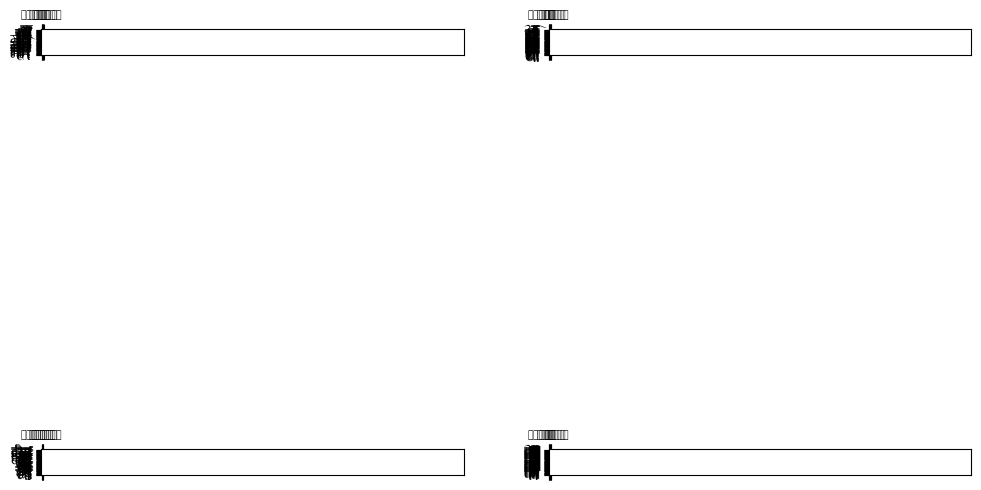

In [70]:
"""It may also be useful to look at attention maps for different examples:"""

# Please do not change anything in the following cell.

def visualize_attention(src_glyphs, tgt_glyphs, attention, axes):
    axes.matshow(attention.numpy(), cmap='bone')

    axes.set_xticks(numpy.arange(len(src_glyphs)), labels=src_glyphs)
    axes.set_yticks(numpy.arange(len(tgt_glyphs)), labels=tgt_glyphs)

# Please do not change anything in the following cell.

pyplot.figure(figsize=(12, 10))

src_id_to_token = inverse_vocabulary(src_tokenizer)
tgt_id_to_token = inverse_vocabulary(tgt_tokenizer)

with torch.no_grad():
    for i, row in train_data.sample(n=4, random_state=69, ignore_index=True).iterrows():
        src_tokens = torch.tensor(src_tokenizer.encode(row['Name']))
        attentions, tgt_tokens = model.attentions(src_tokens, tgt_tokenizer.get_special_tokens()['[EOS]'], max_length=50)
        src_glyphs = apply_inverse_vocab(src_tokens.tolist(), src_id_to_token)
        tgt_glyphs = apply_inverse_vocab(tgt_tokens.tolist(), tgt_id_to_token)
        axes = pyplot.subplot(2, 2, i+1)
        visualize_attention(src_glyphs, tgt_glyphs, attentions, axes)

# Please do not change anything in the following cell.

output_data = []
for _, row in validation_data.iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )
    output_data.append({ 'Name': row['Name'], 'Translation': y_pred })

pd.DataFrame.from_records(output_data).to_csv(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn", "outputs.csv"), index=False
)

In [71]:
# Please do not change anything in the following cell.

# Release resources
if 'trainer' in globals():
    del trainer

if 'model' in globals():
    del model

sync_vram()

In [72]:
"""## Evaluation

In the last few modules, you have implemented different approaches towards transliteration of Indian names to Hindi. To assess how well different systems perform, it is useful to compute different metrics, which assess different properties:

- **Accuracy**: From a parallel corpus, number of translations the model got exactly right. Higher the better. Note that this makes sense only for this task. and lacks granularity.
- **Edit Distance**: Number of edits at the character level (insertions, deletions, substitutions) required to transform your model's outputs to a reference translation. Lower the better.
- **Character Error Rate (CER)**: The rate at which your system/model makes mistakes at the character level. Lower the better.
- **Token Error Rate (TER)**: The rate at which your system/model makes mistakes at the token level. Lower the better. Depending on your tokenizer implementation, could be the same as CER.
- **BiLingual Evaluation Understudy (BLEU)**: Proposed by [Papineni et al., 2002](https://aclanthology.org/P02-1040/), BLEU is a metric that assess the quality of a translation against reference translations through assessing n-gram overlap. Higher the better.

Since accents and half-letters exist as separate characters in the Unicode specification, and can change the interpretation of the output, metrics that operate at the character level will treat these separately.
"""

# Please do not change anything in the following cell.

class Evaluator:
    """ Class to handle all the logic concerning the evaluation of trained models.  """

    def __init__(self, src_tokenizer, tgt_tokenizer) -> None:
        """ Initializes the evaluator.

        Args:
            src_tokenizer (Tokenizer): Tokenizer for input strings in the source language.
            tgt_tokenizer (Tokenizer): Tokenizer for output strings in the target language.
        """

        self.device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.decoding_method = None

    def set_decoding_method(self, decoding_method):
        """ Sets the decoding method to use with models.
                The evaluation function will use the set decoding method to generate outputs from the model.

        Args:
            decoding_method (function): Decoding method.
                Must accept the model instance, the input string, and tokenizers as arguments.
                Can accept additional arguments if required.
        """

        self.decoding_method = decoding_method

    @staticmethod
    def decompose(string):
        """ Decomposes a string into a set of tokens.

        Args:
            string (str): String to decompose.

        Returns:
            list[str]: List of characters from the string.
        """
        return unicodedata.normalize('NFKD', string).encode('utf-8')

    @staticmethod
    def levenshtein_distance(string1, string2):
        """ Computes the levensthein distance between two strings.

        Args:
            string1 (list[any]): Sequence A.
            string2 (list[any]): Sequence B.

        Returns:
            tuple[int, int, int]: Number of insertions + deletions, substitutions and no-ops.
        """

        costs = [
            [ 0 for j in range(len(string2)+1) ]
            for i in range(len(string1)+1)
        ]

        # Prepare matrix of costs.
        for i in range(len(string1)+1): costs[i][0] = i
        for j in range(len(string2)+1): costs[0][j] = j
        for i in range(1, len(string1)+1):
            for j in range(1, len(string2)+1):
                costs[i][j] = min(
                    costs[i][j-1] + 1,
                    costs[i-1][j] + 1,
                    costs[i-1][j-1] + (0 if string1[i-1] == string2[j-1] else 1)
                )

        # Decode matrix in backward manner for actual operation counts.
        c_ins_del, c_sub, c_noop = 0, 0, 0

        i, j = len(string1), len(string2)
        while i > 0 or j > 0:
            if i > 0 and costs[i][j] == costs[i-1][j] + 1:
                c_ins_del += 1
                i -= 1
            elif j > 0 and costs[i][j] == costs[i][j-1] + 1:
                c_ins_del += 1
                j -= 1
            elif i > 0 and j > 0:
                if string1[i-1] == string2[j-1]:
                    c_noop += 1
                else:
                    c_sub += 1
                i, j = i-1, j-1
            else:
                break

        return c_ins_del, c_sub, c_noop

    @staticmethod
    def accuracy(y_true, y_pred):
        """ Computes the accuracy of the predictions, against a reference set of predictions.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: Accuracy score, between 0 and 1.
        """
        return sum(yi_true == yi_pred for yi_true, yi_pred in zip(y_true, y_pred)) / len(y_pred)

    @classmethod
    def char_error_rate(cls, y_true, y_pred):
        """ Computes the character level error rate (CER) of the set of
            predictions against the reference translations.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: CER score, between 0 and 1. Lower the better.
        """

        cer_score = 0

        for yi_true, yi_pred in zip(y_true, y_pred):
            yi_true, yi_pred = cls.decompose(yi_true), cls.decompose(yi_pred)
            c_ins_del, c_sub, c_noop = cls.levenshtein_distance(yi_true, yi_pred)
            cer_score += (c_ins_del + c_sub) / (c_ins_del + c_sub + c_noop)

        return cer_score / len(y_true)

    def token_error_rate(self, y_true, y_pred):
        """ Computes the token level error rate (TER) of the set of
            predictions against the reference translations.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: TER score, between 0 and 1. Lower the better.
        """

        ter_score = 0

        for yi_true, yi_pred in zip(y_true, y_pred):
            yi_true = self.tgt_tokenizer.encode(yi_true, add_start=False, add_end=False)
            yi_pred = self.tgt_tokenizer.encode(yi_pred, add_start=False, add_end=False)
            t_ins_del, t_sub, t_noop = self.levenshtein_distance(yi_true, yi_pred)
            ter_score += (t_ins_del + t_sub) / (t_ins_del + t_sub + t_noop)

        return ter_score / len(y_true)

    @classmethod
    def bleu_score(cls, y_true, y_pred):
        """ Computes the average BLEU score of the set of predictions against the reference translations.

            Uses default parameters and equal weights for all n-grams, with max N = 4. (Thus computes BLEU-4).
            Uses a smoothing method for the case of missing n-grams.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: BLEU-4 score, the higher the better.
        """

        y_true = [ [ cls.decompose(yi) ] for yi in y_true ]
        y_pred = [ cls.decompose(yi) for yi in y_pred ]

        smoothing = bleu_score.SmoothingFunction()

        return bleu_score.corpus_bleu(
            y_true, y_pred,
            smoothing_function=smoothing.method1
        )

    def evaluate(self, model_path, data, reference_outputs, **decoding_kwargs):
        """ Performs the evaluation of a specified model over given data.

        Args:
            model_path (str): Path to load the model from. Must have a model.pt file.
            data (list[str]): List of input strings to translate.
            reference_outputs (list[str]): List of output strings to use as reference.
            decoding_kwargs (dict[str, any]): Additional arguments to forward to the decoding method.
                This could be for instance, max_length for a greedy decoding method.

        Raises:
            ValueError: If the decoding method is not set apriori.
        """

        if self.decoding_method is None:
            raise ValueError(f"{self.evaluate.__name__}: no decoding method is set, assign before use.")

        # Load the model to the active device.
        model = torch.load(os.path.join(model_path, 'model.pt'), map_location=self.device)

        # Set model use parameters.
        model.to(self.device)
        model.eval()

        # Generate outputs.
        generated_outputs = []
        with torch.no_grad():
            for seq_x in data:
                generated_outputs.append(self.decoding_method(
                    model, seq_x, self.src_tokenizer,
                    self.tgt_tokenizer, **decoding_kwargs
                ))

        accuracy_score = self.accuracy(reference_outputs, generated_outputs)
        cer_score      = self.char_error_rate(reference_outputs, generated_outputs)
        ter_score      = self.token_error_rate(reference_outputs, generated_outputs)
        blue_score     = self.bleu_score(reference_outputs, generated_outputs)

        print("EVALUATION:", ">", "accuracy:", f"{accuracy_score:.2%}")
        print("EVALUATION:", ">", "CER     :", f"{cer_score:.2%}")
        print("EVALUATION:", ">", "TER     :", f"{ter_score:.2%}")
        print("EVALUATION:", ">", "BLEU    :", f"{blue_score:.4f}")
        print()

        # Free resources once evaluation is complete.
        del model
        sync_vram()

# Please do not change anything in the following cell.

In [73]:
evaluator = Evaluator(src_tokenizer, tgt_tokenizer)

In [74]:
# Use greedy decoding for producing outputs.
evaluator.set_decoding_method(rnn_greedy_generate)

# Evaluate enc-dec-rnn
print("EVALUATION:", "enc-dec-rnn")
evaluator.evaluate(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec"),
    validation_data['Name'], validation_data['Translation'],
    max_length = rnn_enc_dec_data_params['tgt_padding']
)

EVALUATION: enc-dec-rnn


/tmp/ipykernel_3838105/3311784119.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(model_path, 'model.pt'), map_location=self.device)


EVALUATION: > accuracy: 13.25%
EVALUATION: > CER     : 33.77%
EVALUATION: > TER     : 51.12%
EVALUATION: > BLEU    : 0.5757



In [75]:
# Evaluate enc-dec-rnn-attn
print("EVALUATION:", "enc-dec-rnn-attn")
evaluator.evaluate(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn"),
    validation_data['Name'], validation_data['Translation'],
    max_length = rnn_enc_dec_attn_data_params['tgt_padding']
)


EVALUATION: enc-dec-rnn-attn


/tmp/ipykernel_3838105/3311784119.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(model_path, 'model.pt'), map_location=self.device)


EVALUATION: > accuracy: 22.00%
EVALUATION: > CER     : 33.97%
EVALUATION: > TER     : 49.00%
EVALUATION: > BLEU    : 0.4132

